In [105]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb
import scipy
import time
from bayes_opt import BayesianOptimization 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [106]:
import tensorflow as tf

In [107]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [108]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')
dataset_hc_c_d = pd.read_csv('dataset/HomeCredit_columns_description.csv',encoding="ISO-8859-1")
dataset_pos_cash_b = pd.read_csv('dataset/POS_CASH_balance.csv')
dataset_ins_pay = pd.read_csv('dataset/installments_payments.csv')
dataset_c_c_bal = pd.read_csv('dataset/credit_card_balance.csv')
dataset_br = pd.read_csv('dataset/bureau.csv')
dataset_prev_app = pd.read_csv('dataset/previous_application.csv')
dataset_br_bal = pd.read_csv('dataset/bureau_balance.csv')

In [109]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [110]:
dataset_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

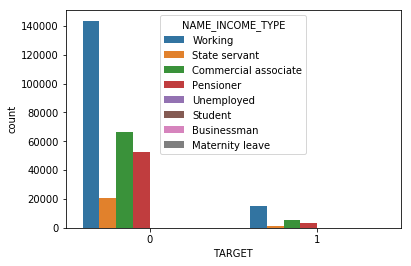

In [116]:
sb.countplot(x='TARGET',hue='NAME_INCOME_TYPE',data=dataset_train)

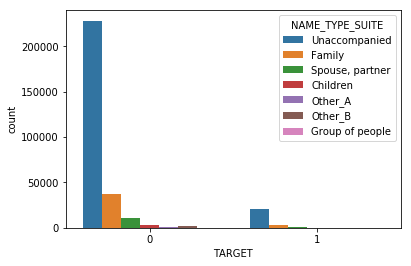

In [114]:
sb.countplot(x='TARGET',hue='NAME_TYPE_SUITE',data=dataset_train)

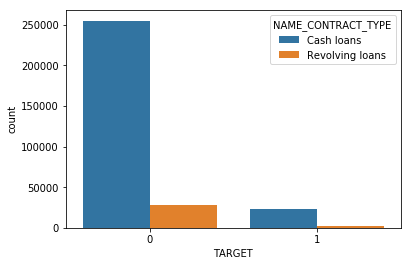

In [113]:
sb.countplot(x='TARGET',hue='NAME_CONTRACT_TYPE',data=dataset_train)

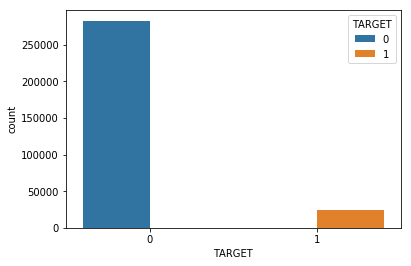

In [111]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train)

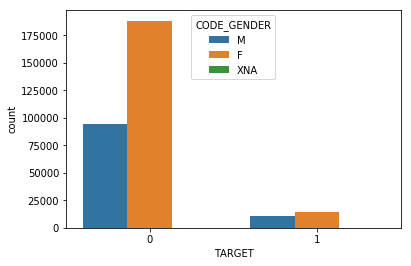

In [112]:
sb.countplot(x='TARGET',hue='CODE_GENDER',data=dataset_train)

In [119]:
dataset_train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [120]:
(dataset_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [129]:
len(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0])

55374

In [128]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    307511.000000
mean        185.547239
std         382.037676
min           0.000000
25%           2.556164
50%           6.079452
75%          15.635616
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

In [140]:
max(dataset_train['DAYS_EMPLOYED'])

365243

In [141]:
len(dataset_train['DAYS_EMPLOYED'] == 365243)

307511

In [142]:
dataset_train['EMP_AN'] = dataset_train['DAYS_EMPLOYED'] == 365243

In [143]:
dataset_train['DAYS_EMPLOYED'] = dataset_train['DAYS_EMPLOYED'].replace({365243: np.nan})

In [144]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    252137.000000
mean          6.531971
std           6.406466
min           0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [134]:
(abs(dataset_train['DAYS_REGISTRATION']/365)).describe()

count    307511.000000
mean         13.660604
std           9.651743
min           0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

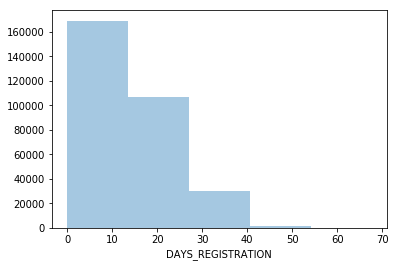

In [136]:
sb.distplot(dataset_train['DAYS_REGISTRATION']/-365,bins=5,kde=False)

In [162]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

0

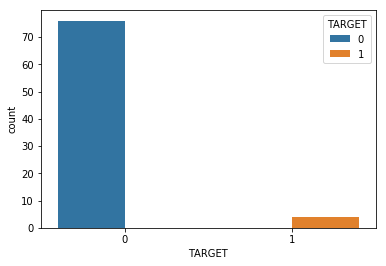

In [155]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50])

In [161]:
dataset_train = dataset_train.drop(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50].index,axis=0)

In [163]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

0

In [124]:
dataset_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [81]:
dataset_train['FLAG_DOCUMENT_18'].isnull().sum()

0

In [82]:
dataset_train['FLAG_DOCUMENT_19'].isnull().sum()

0

In [84]:
dataset_train['FLAG_DOCUMENT_20'].isnull().sum()

0

In [85]:
dataset_train.shape

(307511, 122)

In [86]:
dataset_train = dataset_train.dropna(axis='columns')

In [87]:
dataset_train.shape

(307511, 55)

In [88]:
dataset_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,1,1,MONDAY,11,0,0,0,0,0,0,School,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970.0,-477,1,1,1,1,1,0,2,2,WEDNESDAY,16,0,0,0,0,0,0,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130,-1213.0,-619,1,1,0,1,1,0,2,2,SUNDAY,16,0,0,0,0,0,0,Business Entity Type 3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,State servant,Higher education,Married,House / apartment,0.003122,-18850,-449,-4597.0,-2379,1,1,1,1,0,0,3,3,MONDAY,16,0,0,0,0,1,1,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,Pensioner,Secondary / secondary special,Married,House / apartment,0.018634,-20099,365243,-7427.0,-3514,1,0,0,1,0,0,2,2,WEDNESDAY,14,0,0,0,0,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.019689,-14469,-2019,-14437.0,-3992,1,1,0,1,0,0,2,2,THURSDAY,8,0,0,0,0,0,0,Electricity,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [89]:
dataset_train.groupby('TARGET')['SK_ID_CURR'].nunique()

TARGET
0    282686
1     24825
Name: SK_ID_CURR, dtype: int64

In [90]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(20000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [91]:
dataset_train.shape

(40000, 55)

In [92]:
dataset_train.groupby('TARGET')['SK_ID_CURR'].nunique()

TARGET
0    20000
1    20000
Name: SK_ID_CURR, dtype: int64

In [93]:
dataset_train = dataset_train.sample(frac=1).reset_index(drop=True)

In [94]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,295557,0,Cash loans,F,N,Y,0,270000.0,594121.5,State servant,Higher education,Married,House / apartment,0.004960,-17944,-5340,-8268.0,-1506,1,1,0,1,0,0,2,2,THURSDAY,14,0,0,0,0,0,0,School,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,424137,0,Cash loans,F,Y,N,0,990000.0,412942.5,Commercial associate,Higher education,Separated,House / apartment,0.072508,-14790,-1181,-8820.0,-5516,1,1,0,1,0,0,1,1,TUESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,106409,0,Cash loans,F,Y,Y,1,135000.0,900000.0,Working,Higher education,Married,House / apartment,0.020246,-15964,-1299,-5377.0,-5894,1,1,0,1,1,1,3,3,WEDNESDAY,14,0,0,0,0,0,0,Industry: type 9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,256595,1,Cash loans,F,N,Y,0,337500.0,781920.0,Commercial associate,Higher education,Single / not married,House / apartment,0.072508,-8918,-505,-8777.0,-1603,1,1,0,1,0,0,1,1,MONDAY,19,0,0,0,0,0,0,Construction,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,369007,1,Cash loans,F,N,N,1,292500.0,699808.5,Working,Higher education,Married,House / apartment,0.024610,-14769,-571,-702.0,-3697,1,1,0,1,1,0,2,2,WEDNESDAY,19,0,0,0,0,0,0,Construction,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [95]:
dataset_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [96]:
dataset_hc_c_d.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [97]:
dataset_pos_cash_b.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [98]:
dataset_ins_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [99]:
dataset_c_c_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [100]:
dataset_br.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [101]:
dataset_prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
dataset_br_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [103]:
dataset_train = dataset_train.dropna(axis='rows')

In [104]:
dataset_train["TARGET"].value_counts(dropna=False)

1    20000
0    20000
Name: TARGET, dtype: int64

In [30]:
corr = dataset_train.corr(method='pearson')

In [32]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.9543237234212812
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.8538569235282969
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8016149042218685


In [33]:
#Columnd to remove die to high correlation (Only measured colinearity among pairs of parameters still have to deal
#with multi-colinearity)
columns_to_remove

['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

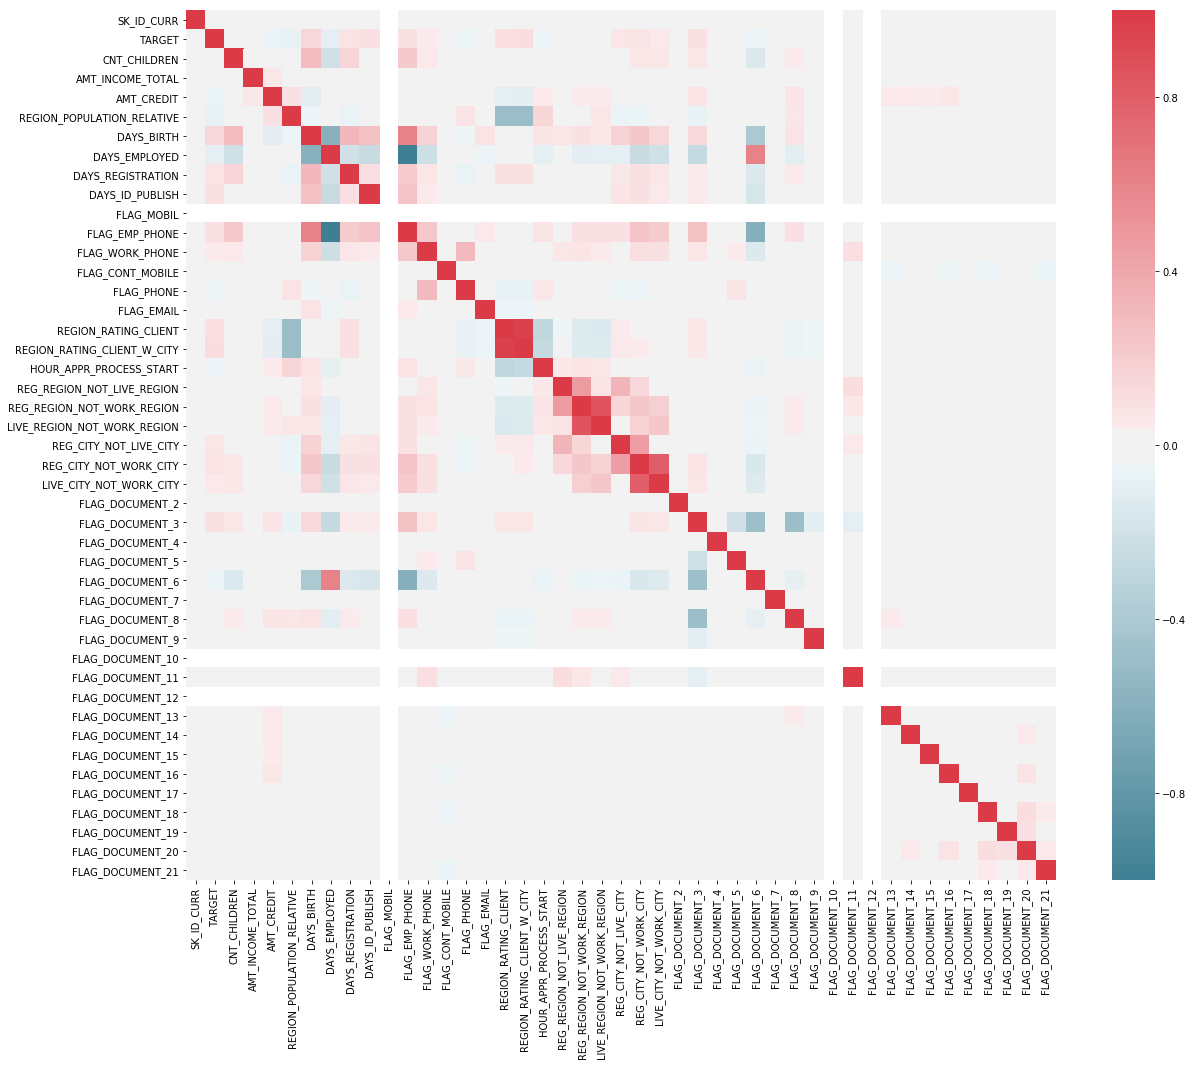

In [34]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [35]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

In [36]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,353444,1,Cash loans,F,N,N,0,135000.0,942300.0,Commercial associate,...,0,0,0,0,0,0,1,0,0,0
1,143010,0,Cash loans,F,N,Y,0,360000.0,904216.5,Working,...,0,0,0,0,0,0,0,0,0,0
2,392134,1,Revolving loans,F,Y,N,0,225000.0,270000.0,Commercial associate,...,0,0,0,0,0,0,0,0,0,0
3,443450,0,Cash loans,F,N,Y,0,157500.0,855000.0,Working,...,0,0,0,0,0,0,0,0,0,0
4,313712,1,Cash loans,F,N,N,0,157500.0,450000.0,Working,...,0,0,0,0,0,0,0,0,0,0


In [37]:
pd.set_option('display.max_columns',None)

In [38]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,353444,1,Cash loans,F,N,N,0,135000.0,942300.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.032561,-18424,-2297,-12485.0,-1880,1,1,0,1,0,0,THURSDAY,17,0,0,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,143010,0,Cash loans,F,N,Y,0,360000.0,904216.5,Working,Secondary / secondary special,Separated,House / apartment,0.032561,-18268,-2769,-4495.0,-1805,1,1,0,1,1,1,WEDNESDAY,12,0,0,Medicine,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,392134,1,Revolving loans,F,Y,N,0,225000.0,270000.0,Commercial associate,Secondary / secondary special,Married,Municipal apartment,0.003818,-14043,-1004,-8035.0,-1109,1,1,0,1,0,0,FRIDAY,6,0,0,Business Entity Type 2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,443450,0,Cash loans,F,N,Y,0,157500.0,855000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,0.028663,-11467,-2236,-3866.0,-3818,1,1,1,1,1,0,FRIDAY,11,0,1,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,313712,1,Cash loans,F,N,N,0,157500.0,450000.0,Working,Higher education,Widow,House / apartment,0.008575,-13727,-106,-7814.0,-2742,1,1,1,1,0,0,WEDNESDAY,13,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','CNT_CHILDREN','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','ORGANIZATION_TYPE']
starttime = time.time()
for column in columns_to_label_encode:
    le = LabelEncoder()
    oe = OneHotEncoder()
    label_encoded = le.fit_transform(dataset_train[column])
    label_encoded = label_encoded.reshape(-1,1)
    one_hot_encoded = oe.fit_transform(label_encoded).toarray()
    df = pd.DataFrame(one_hot_encoded,columns=[column + str(i) for i in range(0,one_hot_encoded.shape[1])])
    df = df.drop([column + "0"],axis=1)
    dataset_train = pd.concat([dataset_train,df],axis=1)
    print(column + " - " + str(dataset_train.shape[0]) + " " + str(dataset_train.shape[1]))
endtime = time.time()
print("Time Elapsed:- ")
print(endtime - starttime)

NAME_CONTRACT_TYPE - 40000 50
CODE_GENDER - 40000 51
FLAG_OWN_CAR - 40000 52
FLAG_OWN_REALTY - 40000 53
CNT_CHILDREN - 40000 62
NAME_INCOME_TYPE - 40000 69
NAME_EDUCATION_TYPE - 40000 73
NAME_FAMILY_STATUS - 40000 78
NAME_HOUSING_TYPE - 40000 83
ORGANIZATION_TYPE - 40000 140
Time Elapsed:- 
1.1608607769012451


In [40]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE1,CODE_GENDER1,FLAG_OWN_CAR1,FLAG_OWN_REALTY1,CNT_CHILDREN1,CNT_CHILDREN2,CNT_CHILDREN3,CNT_CHILDREN4,CNT_CHILDREN5,CNT_CHILDREN6,CNT_CHILDREN7,CNT_CHILDREN8,CNT_CHILDREN9,NAME_INCOME_TYPE1,NAME_INCOME_TYPE2,NAME_INCOME_TYPE3,NAME_INCOME_TYPE4,NAME_INCOME_TYPE5,NAME_INCOME_TYPE6,NAME_INCOME_TYPE7,NAME_EDUCATION_TYPE1,NAME_EDUCATION_TYPE2,NAME_EDUCATION_TYPE3,NAME_EDUCATION_TYPE4,NAME_FAMILY_STATUS1,NAME_FAMILY_STATUS2,NAME_FAMILY_STATUS3,NAME_FAMILY_STATUS4,NAME_FAMILY_STATUS5,NAME_HOUSING_TYPE1,NAME_HOUSING_TYPE2,NAME_HOUSING_TYPE3,NAME_HOUSING_TYPE4,NAME_HOUSING_TYPE5,ORGANIZATION_TYPE1,ORGANIZATION_TYPE2,ORGANIZATION_TYPE3,ORGANIZATION_TYPE4,ORGANIZATION_TYPE5,ORGANIZATION_TYPE6,ORGANIZATION_TYPE7,ORGANIZATION_TYPE8,ORGANIZATION_TYPE9,ORGANIZATION_TYPE10,ORGANIZATION_TYPE11,ORGANIZATION_TYPE12,ORGANIZATION_TYPE13,ORGANIZATION_TYPE14,ORGANIZATION_TYPE15,ORGANIZATION_TYPE16,ORGANIZATION_TYPE17,ORGANIZATION_TYPE18,ORGANIZATION_TYPE19,ORGANIZATION_TYPE20,ORGANIZATION_TYPE21,ORGANIZATION_TYPE22,ORGANIZATION_TYPE23,ORGANIZATION_TYPE24,ORGANIZATION_TYPE25,ORGANIZATION_TYPE26,ORGANIZATION_TYPE27,ORGANIZATION_TYPE28,ORGANIZATION_TYPE29,ORGANIZATION_TYPE30,ORGANIZATION_TYPE31,ORGANIZATION_TYPE32,ORGANIZATION_TYPE33,ORGANIZATION_TYPE34,ORGANIZATION_TYPE35,ORGANIZATION_TYPE36,ORGANIZATION_TYPE37,ORGANIZATION_TYPE38,ORGANIZATION_TYPE39,ORGANIZATION_TYPE40,ORGANIZATION_TYPE41,ORGANIZATION_TYPE42,ORGANIZATION_TYPE43,ORGANIZATION_TYPE44,ORGANIZATION_TYPE45,ORGANIZATION_TYPE46,ORGANIZATION_TYPE47,ORGANIZATION_TYPE48,ORGANIZATION_TYPE49,ORGANIZATION_TYPE50,ORGANIZATION_TYPE51,ORGANIZATION_TYPE52,ORGANIZATION_TYPE53,ORGANIZATION_TYPE54,ORGANIZATION_TYPE55,ORGANIZATION_TYPE56,ORGANIZATION_TYPE57
0,353444,1,Cash loans,F,N,N,0,135000.0,942300.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.032561,-18424,-2297,-12485.0,-1880,1,1,0,1,0,0,THURSDAY,17,0,0,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,143010,0,Cash loans,F,N,Y,0,360000.0,904216.5,Working,Secondary / secondary special,Separated,House / apartment,0.032561,-18268,-2769,-4495.0,-1805,1,1,0,1,1,1,WEDNESDAY,12,0,0,Medicine,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,392134,1,Revolving loans,F,Y,N,0,225000.0,270000.0,Commercial associate,Secondary / secondary special,Married,Municipal apartment,0.003818,-14043,-1004,-8035.0,-1109,1,1,0,1,0,0,FRIDAY,6,0,0,Business Entity Type 2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1

In [41]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','CNT_CHILDREN','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START']
dataset_train = dataset_train.drop(columns_to_label_encode,axis=1)

In [42]:
dataset_train.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE1,CODE_GENDER1,FLAG_OWN_CAR1,FLAG_OWN_REALTY1,CNT_CHILDREN1,CNT_CHILDREN2,CNT_CHILDREN3,CNT_CHILDREN4,CNT_CHILDREN5,CNT_CHILDREN6,CNT_CHILDREN7,CNT_CHILDREN8,CNT_CHILDREN9,NAME_INCOME_TYPE1,NAME_INCOME_TYPE2,NAME_INCOME_TYPE3,NAME_INCOME_TYPE4,NAME_INCOME_TYPE5,NAME_INCOME_TYPE6,NAME_INCOME_TYPE7,NAME_EDUCATION_TYPE1,NAME_EDUCATION_TYPE2,NAME_EDUCATION_TYPE3,NAME_EDUCATION_TYPE4,NAME_FAMILY_STATUS1,NAME_FAMILY_STATUS2,NAME_FAMILY_STATUS3,NAME_FAMILY_STATUS4,NAME_FAMILY_STATUS5,NAME_HOUSING_TYPE1,NAME_HOUSING_TYPE2,NAME_HOUSING_TYPE3,NAME_HOUSING_TYPE4,NAME_HOUSING_TYPE5,ORGANIZATION_TYPE1,ORGANIZATION_TYPE2,ORGANIZATION_TYPE3,ORGANIZATION_TYPE4,ORGANIZATION_TYPE5,ORGANIZATION_TYPE6,ORGANIZATION_TYPE7,ORGANIZATION_TYPE8,ORGANIZATION_TYPE9,ORGANIZATION_TYPE10,ORGANIZATION_TYPE11,ORGANIZATION_TYPE12,ORGANIZATION_TYPE13,ORGANIZATION_TYPE14,ORGANIZATION_TYPE15,ORGANIZATION_TYPE16,ORGANIZATION_TYPE17,ORGANIZATION_TYPE18,ORGANIZATION_TYPE19,ORGANIZATION_TYPE20,ORGANIZATION_TYPE21,ORGANIZATION_TYPE22,ORGANIZATION_TYPE23,ORGANIZATION_TYPE24,ORGANIZATION_TYPE25,ORGANIZATION_TYPE26,ORGANIZATION_TYPE27,ORGANIZATION_TYPE28,ORGANIZATION_TYPE29,ORGANIZATION_TYPE30,ORGANIZATION_TYPE31,ORGANIZATION_TYPE32,ORGANIZATION_TYPE33,ORGANIZATION_TYPE34,ORGANIZATION_TYPE35,ORGANIZATION_TYPE36,ORGANIZATION_TYPE37,ORGANIZATION_TYPE38,ORGANIZATION_TYPE39,ORGANIZATION_TYPE40,ORGANIZATION_TYPE41,ORGANIZATION_TYPE42,ORGANIZATION_TYPE43,ORGANIZATION_TYPE44,ORGANIZATION_TYPE45,ORGANIZATION_TYPE46,ORGANIZATION_TYPE47,ORGANIZATION_TYPE48,ORGANIZATION_TYPE49,ORGANIZATION_TYPE50,ORGANIZATION_TYPE51,ORGANIZATION_TYPE52,ORGANIZATION_TYPE53,ORGANIZATION_TYPE54,ORGANIZATION_TYPE55,ORGANIZATION_TYPE56,ORGANIZATION_TYPE57
0,353444,1,135000.0,942300.0,0.032561,-18424,-2297,-12485.0,-1880,1,1,0,1,0,0,17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,143010,0,360000.0,904216.5,0.032561,-18268,-2769,-4495.0,-1805,1,1,0,1,1,1,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,392134,1,225000.0,270000.0,0.003818,-14043,-1004,-8035.0,-1109,1,1,0,1,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,443450,0,157500.0,855000.0,0.028663,-11467,-2236,-3866.0,-3818,1,1,1,1,1,0,11,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [43]:
X = dataset_train.iloc[:,2:]
y = dataset_train['TARGET']

In [44]:
X.shape

(40000, 127)

In [45]:
y.shape

(40000,)

In [46]:
#Removing statistically insignificant variables here
_,p_values = f_classif(X,y)
stat_insigf_cols = []
p_values_g_thresh = (p_values > 0.05)
for i in range(0,len(p_values_g_thresh)):
    if p_values_g_thresh[i] == 1:
        stat_insigf_cols.append(i)  
X = X.drop(X.columns[stat_insigf_cols],axis=1)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 7 24 26] are constant.
  UserWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [47]:
X.shape

(40000, 73)

In [48]:
cols_to_scale = ['AMT_CREDIT','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION']
scaler = StandardScaler()
scaled_values = pd.DataFrame(scaler.fit_transform(X[cols_to_scale]),columns=cols_to_scale)
X = X.drop(cols_to_scale,axis=1)
X = pd.concat([X,scaled_values],axis=1)

In [49]:
X.head()

,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_10,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,NAME_CONTRACT_TYPE1,CODE_GENDER1,FLAG_OWN_CAR1,CNT_CHILDREN1,CNT_CHILDREN2,CNT_CHILDREN3,CNT_CHILDREN4,NAME_INCOME_TYPE1,NAME_INCOME_TYPE3,NAME_INCOME_TYPE4,NAME_INCOME_TYPE6,NAME_INCOME_TYPE7,NAME_EDUCATION_TYPE1,NAME_EDUCATION_TYPE2,NAME_EDUCATION_TYPE3,NAME_EDUCATION_TYPE4,NAME_FAMILY_STATUS1,NAME_FAMILY_STATUS3,NAME_FAMILY_STATUS5,NAME_HOUSING_TYPE1,NAME_HOUSING_TYPE4,NAME_HOUSING_TYPE5,ORGANIZATION_TYPE1,ORGANIZATION_TYPE2,ORGANIZATION_TYPE4,ORGANIZATION_TYPE5,ORGANIZATION_TYPE7,ORGANIZATION_TYPE11,ORGANIZATION_TYPE12,ORGANIZATION_TYPE14,ORGANIZATION_TYPE20,ORGANIZATION_TYPE27,ORGANIZATION_TYPE29,ORGANIZATION_TYPE30,ORGANIZATION_TYPE31,ORGANIZATION_TYPE34,ORGANIZATION_TYPE38,ORGANIZATION_TYPE39,ORGANIZATION_TYPE40,ORGANIZATION_TYPE41,ORGANIZATION_TYPE42,ORGANIZATION_TYPE43,ORGANIZATION_TYPE47,ORGANIZATION_TYPE50,ORGANIZATION_TYPE51,ORGANIZATION_TYPE52,ORGANIZATION_TYPE54,ORGANIZATION_TYPE56,ORGANIZATION_TYPE57,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION
0,-1880,1,1,0,0,17,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.964676,0.970143,-0.681036,-0.421749,-2.254432
1,-1805,1,1,0,1,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.863922,0.970143,-0.644882,-0.425345,0.077515
2,-1109,1,1,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.813962,-1.252000,0.334269,-0.411897,-0.955663
3,-3818,1,1,1,1,11,0,1,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.733715,0.668786,0.931262,-0.421284,0.261094
4,-2742,1,1,1,0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.337754,-0.884233,0.407503,-0.405055,-0.891163


In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [51]:
X_train.shape

(32000, 73)

In [52]:
X_test.shape

(8000, 73)

In [53]:
def generate_classifier_report(classifier,predictions,predictions_prob,name):
    print(classification_report(y_test,predictions))
    logit_roc_score = roc_auc_score(y_test,predictions)
    fpr, tpr, thresholds = roc_curve(y_test,predictions_prob)
    plt.figure()
    plt.plot(fpr,tpr,label=name + " AUC score:- " + str(logit_roc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate (FP / (FP + TN))')
    plt.ylabel('True Positive Rate (TP / (TP + FN))')
    plt.title('Receiver Operating Characteristics Curve')
    plt.legend(loc="lower right")
    plt.savefig(name + "_roc_curve")
    plt.show()

In [54]:
clf = LogisticRegression(C=0.4,max_iter = 1000)
clf.fit(X_train,y_train)

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
prediction = clf.predict(X_test)

In [56]:
accuracy_score(y_test,prediction)

0.60825

In [58]:
confusion_matrix(y_test,prediction)

array([[2499, 1500],
       [1634, 2367]])

             precision    recall  f1-score   support

          0       0.60      0.62      0.61      3999
          1       0.61      0.59      0.60      4001

avg / total       0.61      0.61      0.61      8000



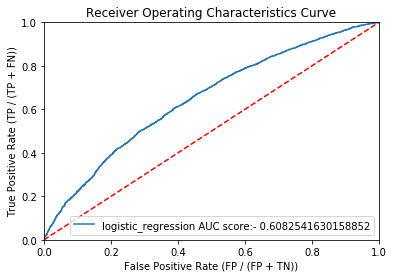

In [59]:
generate_classifier_report(clf,prediction,clf.predict_proba(X_test)[:,1],name="logistic_regression")

In [60]:
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
prediction = classifier.predict(X_test)

In [62]:
confusion_matrix(y_test,prediction)

array([[2617, 1382],
       [2034, 1967]])

In [63]:
accuracy_score(y_test,prediction)

0.573

             precision    recall  f1-score   support

          0       0.56      0.65      0.61      3999
          1       0.59      0.49      0.54      4001

avg / total       0.58      0.57      0.57      8000



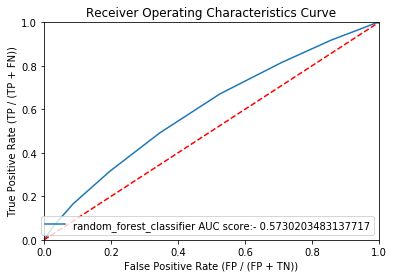

In [64]:
generate_classifier_report(classifier,prediction,classifier.predict_proba(X_test)[:,1],"random_forest_classifier")

In [65]:
boosting = XGBClassifier(alpha=1,eval_metric='logloss')
boosting.fit(X_train,y_train)

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='logloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [66]:
pred = boosting.predict(X_test)
accuracy_score(y_test,pred)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.62375

In [67]:
confusion_matrix(y_test,pred)

array([[2458, 1541],
       [1469, 2532]])

             precision    recall  f1-score   support

          0       0.63      0.61      0.62      3999
          1       0.62      0.63      0.63      4001

avg / total       0.62      0.62      0.62      8000



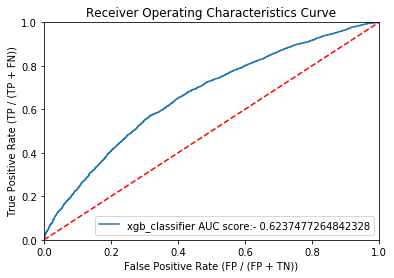

In [68]:
generate_classifier_report(boosting,pred,boosting.predict_proba(X_test)[:,1],'xgb_classifier')

In [69]:
X = tf.placeholder(shape=[None,61],dtype=tf.float32)
y = tf.placeholder(shape=[None],dtype=tf.int64)

In [70]:
weights = {
    'W1': tf.Variable(tf.truncated_normal(shape=[73,42])),
    'W2': tf.Variable(tf.truncated_normal(shape=[42,25])),
    'W3': tf.Variable(tf.truncated_normal(shape=[25,10])),
    'W4': tf.Variable(tf.truncated_normal(shape=[10,2]))
}
biases = {
    'b1': tf.Variable(tf.truncated_normal(shape=[42])),
    'b2': tf.Variable(tf.truncated_normal(shape=[25])),
    'b3': tf.Variable(tf.truncated_normal(shape=[10])),
    'b4': tf.Variable(tf.truncated_normal(shape=[2]))
}

In [71]:
def get_model(X,weights,biases):
    op1 = tf.add(tf.matmul(X,weights['W1']),biases['b1'])
    relu_op1 = tf.nn.relu(op1) 
    op2 = tf.add(tf.matmul(relu_op1,weights['W2']),biases['b2'])
    relu_op2 = tf.nn.relu(op2)
    op3 = tf.add(tf.matmul(relu_op2,weights['W3']),biases['b3'])
    relu_op3 = tf.nn.relu(op3)
    op4 = tf.add(tf.matmul(relu_op3,weights['W4']),biases['b4'])
    return op4

In [72]:
pred = get_model(X,weights,biases)
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=pred))
train_step = optimizer.minimize(loss)

In [73]:
#Improve accuracy here
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(0,10):
        cost = 0
        total_batch = X_train.shape[0]/100
        X_batches = np.array_split(X_train,total_batch)
        y_batches = np.array_split(y_train,total_batch)
        for j in range(0,int(total_batch)):
            _,c = sess.run([train_step,loss],feed_dict={
                X: X_batches[j],
                y: y_batches[j]
            })
            cost = cost + c/total_batch
        print("Epoch:- " + str(i) + " Cost:- " + str(cost))
    correct_prediction = tf.equal(tf.argmax(pred,1),y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
    print("Accuracy:- " + str(accuracy.eval({X: X_test,y: y_test})))

ValueError: Cannot feed value of shape (100, 73) for Tensor 'Placeholder:0', which has shape '(?, 61)'

In [ ]:
clf = SVC(gamma=0.001, C=1.0, kernel='poly')
clf.fit(X_train,y_train)

In [ ]:
pred = clf.predict(X_test)
accuracy_score(y_test,pred)

In [ ]:
confusion_matrix(y_test,pred).ravel()

In [ ]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],'svc')